In [ ]:
# Connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile

local_zip = '/content/drive/MyDrive/images.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/')
zip_ref.close()

In [ ]:
!sudo apt -y install libportaudio2
!pip install -q --use-deprecated=legacy-resolver tflite-model-maker
!pip install -q pycocotools
!pip install -q opencv-python-headless==4.1.2.30
!pip uninstall -y tensorflow && pip install -q tensorflow==2.8.0

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  libportaudio2
0 upgraded, 1 newly installed, 0 to remove and 45 not upgraded.
Need to get 64.6 kB of archives.
After this operation, 215 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libportaudio2 amd64 19.6.0-1 [64.6 kB]
Fetched 64.6 kB in 1s (109 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype


In [ ]:
import numpy as np
import os

from tflite_model_maker.config import QuantizationConfig
from tflite_model_maker.config import ExportFormat
from tflite_model_maker import model_spec
from tflite_model_maker import object_detector

import tensorflow as tf
assert tf.__version__.startswith('2')

tf.get_logger().setLevel('ERROR')
from absl import logging
logging.set_verbosity(logging.ERROR)

In [ ]:
spec = model_spec.get('efficientdet_lite3')

In [ ]:
train_dir = "/content/images/train"
val_dir = "/content/images/validate"
test_dir = "/content/images/test"
label_map = ["botol kaca", "botol plastik", "kaleng"]

train_data = object_detector.DataLoader.from_pascal_voc(train_dir, train_dir, label_map)
validation_data = object_detector.DataLoader.from_pascal_voc(val_dir, val_dir, label_map)
test_data = object_detector.DataLoader.from_pascal_voc(test_dir, test_dir, label_map)

In [ ]:
model = object_detector.create(
    train_data, 
    model_spec=spec, 
    batch_size=8, 
    train_whole_model=True, 
    epochs=20, 
    validation_data=validation_data)

Epoch 1/20
131/131 [==============================] - 159s 855ms/step - det_loss: 0.8583 - cls_loss: 0.6160 - box_loss: 0.0048 - reg_l2_loss: 0.0928 - loss: 0.9511 - learning_rate: 0.0090 - gradient_norm: 3.1076 - val_det_loss: 0.4721 - val_cls_loss: 0.3961 - val_box_loss: 0.0015 - val_reg_l2_loss: 0.0929 - val_loss: 0.5650
Epoch 2/20
131/131 [==============================] - 108s 827ms/step - det_loss: 0.3903 - cls_loss: 0.3082 - box_loss: 0.0016 - reg_l2_loss: 0.0931 - loss: 0.4834 - learning_rate: 0.0098 - gradient_norm: 4.2262 - val_det_loss: 0.5401 - val_cls_loss: 0.4549 - val_box_loss: 0.0017 - val_reg_l2_loss: 0.0934 - val_loss: 0.6335
Epoch 3/20
131/131 [==============================] - 108s 826ms/step - det_loss: 0.3154 - cls_loss: 0.2512 - box_loss: 0.0013 - reg_l2_loss: 0.0936 - loss: 0.4090 - learning_rate: 0.0096 - gradient_norm: 3.5603 - val_det_loss: 0.2528 - val_cls_loss: 0.1816 - val_box_loss: 0.0014 - val_reg_l2_loss: 0.0937 - val_loss: 0.3466
Epoch 4/20
131/131 [==

In [ ]:
model.evaluate(test_data)

3/3 [==============================] - 20s 3s/step



{'AP': 0.90627086,
 'AP50': 0.99205995,
 'AP75': 0.9800082,
 'AP_/botol kaca': 0.8857821,
 'AP_/botol plastik': 0.91427076,
 'AP_/kaleng': 0.91875976,
 'APl': 0.9133504,
 'APm': 0.842405,
 'APs': -1.0,
 'ARl': 0.95755714,
 'ARm': 0.902963,
 'ARmax1': 0.8927619,
 'ARmax10': 0.9492381,
 'ARmax100': 0.95042855,
 'ARs': -1.0}

In [ ]:
model.export(export_dir='.', tflite_filename='waste.tflite', export_format=[ExportFormat.TFLITE, ExportFormat.LABEL])

In [ ]:
model.evaluate_tflite('waste.tflite', test_data)

150/150 [==============================] - 1188s 8s/step



{'AP': 0.8908541,
 'AP50': 0.9918735,
 'AP75': 0.97780365,
 'AP_/botol kaca': 0.8728876,
 'AP_/botol plastik': 0.8980601,
 'AP_/kaleng': 0.9016147,
 'APl': 0.9012875,
 'APm': 0.804978,
 'APs': -1.0,
 'ARl': 0.9224271,
 'ARm': 0.83925927,
 'ARmax1': 0.88304764,
 'ARmax10': 0.91161907,
 'ARmax100': 0.91161907,
 'ARs': -1.0}

In [ ]:
from google.colab import files
files.download('waste.tflite')
files.download('labels.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import cv2

from PIL import Image

model_path = 'waste.tflite'

# Load the labels into a list
classes = ['???'] * model.model_spec.config.num_classes
label_map = model.model_spec.config.label_map
for label_id, label_name in label_map.as_dict().items():
  classes[label_id-1] = label_name

# Define a list of colors for visualization
COLORS = np.random.randint(0, 255, size=(len(classes), 3), dtype=np.uint8)

def preprocess_image(image_path, input_size):
  """Preprocess the input image to feed to the TFLite model"""
  img = tf.io.read_file(image_path)
  img = tf.io.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.uint8)
  original_image = img
  resized_img = tf.image.resize(img, input_size)
  resized_img = resized_img[tf.newaxis, :]
  resized_img = tf.cast(resized_img, dtype=tf.uint8)
  return resized_img, original_image


def detect_objects(interpreter, image, threshold):
  """Returns a list of detection results, each a dictionary of object info."""

  signature_fn = interpreter.get_signature_runner()

  # Feed the input image to the model
  output = signature_fn(images=image)

  # Get all outputs from the model
  count = int(np.squeeze(output['output_0']))
  scores = np.squeeze(output['output_1'])
  classes = np.squeeze(output['output_2'])
  boxes = np.squeeze(output['output_3'])

  results = []
  for i in range(count):
    if scores[i] >= threshold:
      result = {
        'bounding_box': boxes[i],
        'class_id': classes[i],
        'score': scores[i]
      }
      results.append(result)
  return results


def run_odt_and_draw_results(image_path, interpreter, threshold=0.5):
  """Run object detection on the input image and draw the detection results"""
  # Load the input shape required by the model
  _, input_height, input_width, _ = interpreter.get_input_details()[0]['shape']

  # Load the input image and preprocess it
  preprocessed_image, original_image = preprocess_image(
      image_path,
      (input_height, input_width)
    )

  # Run object detection on the input image
  results = detect_objects(interpreter, preprocessed_image, threshold=threshold)

  # Plot the detection results on the input image
  original_image_np = original_image.numpy().astype(np.uint8)
  for obj in results:
    # Convert the object bounding box from relative coordinates to absolute
    # coordinates based on the original image resolution
    ymin, xmin, ymax, xmax = obj['bounding_box']
    xmin = int(xmin * original_image_np.shape[1])
    xmax = int(xmax * original_image_np.shape[1])
    ymin = int(ymin * original_image_np.shape[0])
    ymax = int(ymax * original_image_np.shape[0])

    # Find the class index of the current object
    class_id = int(obj['class_id'])

    # Draw the bounding box and label on the image
    color = [int(c) for c in COLORS[class_id]]
    cv2.rectangle(original_image_np, (xmin, ymin), (xmax, ymax), color, 2)
    # Make adjustments to make the label visible for all objects
    y = ymin - 15 if ymin - 15 > 15 else ymin + 15
    label = "{}: {:.0f}%".format(classes[class_id], obj['score'] * 100)
    cv2.putText(original_image_np, label, (xmin, y),
        cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

  # Return the final image
  original_uint8 = original_image_np.astype(np.uint8)
  return original_uint8

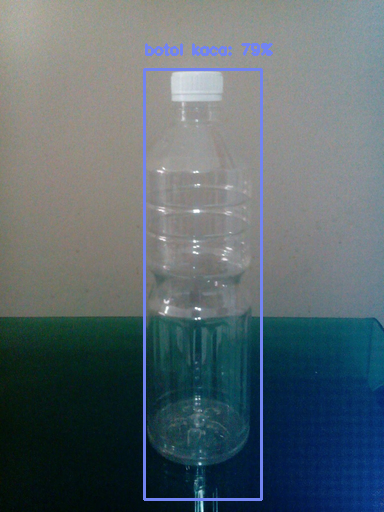

In [ ]:
INPUT_IMAGE_URL = "https://1.bp.blogspot.com/-15iMcFlk9rc/VxQrObXkF9I/AAAAAAAAUWo/LUhvuow7mEc-gAo7Hk0PmqeMbwgQydCdgCLcB/s1600/Air%2BMineral%2B1%2BLiter.jpg" #@param {type:"string"}
DETECTION_THRESHOLD =  0.3#@param {type:"number"}

TEMP_FILE = '/tmp/image.png'

!wget -q -O $TEMP_FILE $INPUT_IMAGE_URL
im = Image.open(TEMP_FILE)
im.thumbnail((512, 512), Image.ANTIALIAS)
im.save(TEMP_FILE, 'PNG')

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

# Run inference and draw detection result on the local copy of the original file
detection_result_image = run_odt_and_draw_results(
    TEMP_FILE,
    interpreter,
    threshold=DETECTION_THRESHOLD
)

# Show the detection result
Image.fromarray(detection_result_image)